In [1]:
# https://stackoverflow.com/questions/34478398/import-local-function-from-a-module-housed-in-another-directory-with-relative-im

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from common.utils import get_data_urls, fetch_data, get_labeled_files

In [2]:
#data_urls = get_data_urls()
#fetch_data(data_urls)

data_files, class_labels = get_labeled_files()

In [3]:
from sklearn.model_selection import train_test_split

train_files, test_files, y_train, y_test = train_test_split(data_files, class_labels,
                                                            test_size=0.2, random_state=44)
print(f"Training set size is\t {len(train_files)}")
print(f"Test set size is\t {len(test_files)}")

Training set size is	 7479
Test set size is	 1870


In [29]:
from common.message import Message
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

import pandas as pd
import mailparser

class MessageTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, input="message"):
        '''string {‘filename’, ‘file’, ‘content’}, '''
        self.input = input
        self.messages = []
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        '''X is a list of files'''
        feature_aggregator = []
        if isinstance(X, str):
             raise ValueError("Must be a list or iterable, not a string")
        for x in X:
            try:
                if self.input == "content":
                    mailparser_obj = mailparser.parse_from_string(x)
                elif self.input == "file":
                    mailparser_obj = mailparser.parse_from_file_obj(x)
                elif self.input == "filename":
                    mailparser_obj = mailparser.parse_from_file(x)
                elif self.input == "message":
                    feature_aggregator.append(x.extract_features())
                    continue                
                feature_aggregator.append(Message(mailparser_obj).extract_features())
            except OSError:
                print("OS ERROR")
            
        return pd.DataFrame.from_records(feature_aggregator)


pipeline = Pipeline([
    ("message_trf", MessageTransformer()),
    ("vectorizer", 
         ColumnTransformer([
            ("tdidf_body_vectorizer", TfidfVectorizer(max_features=5000), "body_tokens"),
         ])
    )
])

IndentationError: expected an indented block (<ipython-input-29-ece7a808385a>, line 34)

In [28]:
from mailparser import mailparser
from common.message import Message

N = 1000

messages = []
for i, message in enumerate(train_files[:N]):
    try:
        m = Message(mailparser.parse_from_file(message))
    except OSError:
        print("OS ERROR")
        continue
    messages.append(m)

labels = y_train[:N]

features = pipeline.fit_transform(messages, labels)

More than one match found for (?:with(?! cipher)\s+(?P<with>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+id|\s+for|\s+via|;)) in from unknown HELO mfrenchw2k mfrench42@62.254.163.42 with login by smtp.mail.vip.sc5.yahoo.com with SMTP; 13 Aug 2002 09:18:55 -0000
More than one match found for (?:with(?! cipher)\s+(?P<with>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+id|\s+for|\s+via|;)) in from unknown HELO mfrenchw2k mfrench42@62.254.163.42 with login by smtp.mail.vip.sc5.yahoo.com with SMTP; 13 Aug 2002 09:18:55 -0000
More than one match found for (?:(?:^|\s)from\s+(?P<from>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+by|\s+with(?! cipher)|\s+id|\s+for|\s+via|;)) in from chekitb5876.com 195.27.92.154 by asptown.co.kr 211.52.47.8 with Nmail V3.1 20010905 S for <jm@netnoteinc.com> from <jimmiester@hanmesoft.co.kr>; Sun, 02 Jun 2002 02:37:30 +0900
More than one match found for (?:(?:^|\s)from\s+(?P<from>.+?)(?:\s*[(]?envelope-from|\s*

AttributeError: 'Message' object has no attribute 'body'

In [27]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

parameters = {
    "lambda": (0.0, 0.1, 1.0, 5.0),
    "alpha": (0.0, 0.1, 1.0, 5.0),
}
xgb_clf = xgb.XGBClassifier(booster="gblinear")
clf = GridSearchCV(xgb_clf, parameters)
clf.fit(features, labels)

NameError: name 'features' is not defined

In [20]:
from common.database_populator import DatabasePopulator

db_populator = DatabasePopulator("../db/spam.db")
db_populator.populate_schema("../schema.sql")
db_populator.populate_message_table(messages, y_train[:1000])

vectorizer = pipeline["vectorizer"].named_transformers_["tdidf_body_vectorizer"]
coefficients = []
for i in zip(vectorizer.get_feature_names(), xgb_clf.coef_):
    coefficients.append(i)

db_populator.populate_feature_table(coefficients)

In [17]:
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier().fit(test, y_train[:1000])
dummy_train_accuracy = np.mean(cross_val_score(dummy_clf, test, y_train[:1000], cv=5))
xgb_train_accuracy = np.mean(cross_val_score(xgb_clf, test, y_train[:1000], cv=5))
print("XGB Accuracy:\t", xgb_train_accuracy)
print("Dummy Accuracy\t", dummy_train_accuracy)

XGB Accuracy:	 0.9399999999999998
Dummy Accuracy	 0.623


In [22]:
import seaborn as sns

<AxesSubplot:ylabel='Density'>

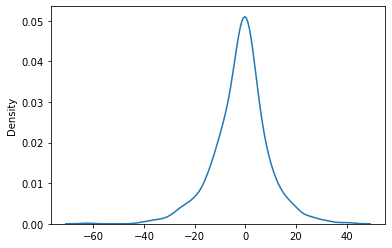

In [23]:
sns.kdeplot(xgb_clf.coef_)

In [723]:
import joblib

joblib.dump(vectorizer, "vectorizer.pkl")

['vectorizer.pkl']